`λ` is an `object` for fluent function composition in `"python"` based on the `toolz` library.

1.  [__Motivation__](#Motivation)
2. [__Source__](#Source)
3. [__Tests__](#Tests)

#### Motivation

[Function composition](https://en.wikipedia.org/wiki/Function_composition) is a common task in mathematics and modern programming.
Object oriented function composition often breaks with conventional representations.
The `toolz` library provides a set of functional programming objects to `compose` and `pipe` functions together.
`compose` and `pipe` are top level composition functions that how two different typographic conventions.

In the `toolz` example, both `f and g` are the same

1. `compose` mimics a symbollic function composition.

        f = compose(type, len, range)
    
1. `pipe` allows a fluent composition.

        g = lambda x: pipe(x, range, len, type)
        def h(x: int) -> type: return pipe(x, range, len, type)
        
The typology of the `compose` composition is destructive to the flow of literature because it must be read `reversed`. 
`pipe` on the other hand supplements the narrative providing literate compositions aligned with the direction of the literature.

From a learning perspective, my experience with `poser` & its predecessors have taught me a lot about the pythonic data model.
`Compose` expresses a near complete symbollic API for function composition.

In [1]:
    import toolz, abc, inspect, functools, typing, importlib, urllib, builtins, json, pathlib, operator, itertools, fnmatch, ast, sys
    from toolz.curried import *
    __all__ = "λ Λ".split()

#### Source

`Compose` augments `toolz.Compose` to provide a fluent & symbollic object for function composition in python.

In [2]:
    class Composition(toolz.functoolz.Compose):        
        __slots__ = toolz.functoolz.Compose.__slots__ + tuple("args kwargs exceptions".split())
        
        def __init__(self, funcs=None, *args, **kwargs): 
            """`Compose` stores `args` and `kwargs` like a partial."""
            super().__init__(funcs or (I,)); self.args, self.exceptions, self.kwargs = args, kwargs.pop('exceptions', tuple()), kwargs
        
        def __iter__(x): yield x.first; yield from x.funcs
        
        def __call__(x, *tuple, **dict):
            tuple, dict = x.args + tuple, {**x.kwargs, **dict}
            for callable in x: 
                try:
                    tuple, dict = (callable(*tuple, **dict),), {}
                    object = tuple[0]
                    if inspect.iscoroutine(object): 
                        try: object = __import__('asyncio').run(object)
                        except RuntimeError: 
                            __import__('nest_asyncio').apply()
                            object = __import__('asyncio').run(object)
                        tuple = (object,) + tuple[1:] 
                except x.exceptions as Exception: return Ø(Exception)
            return object
        
        def partial(this, object=None, *args, **kwargs):
            """append a `partial` an `object` to `this` composition."""
            if isinstance(this, type) and issubclass(this, Composition): this = this()
            if not isinstance(object, Λ):
                if object == None: return this
                if isinstance(object, slice): return type(this)(funcs=list(this)[object])
            if args or kwargs: object = toolz.partial(object, *args, **kwargs)                
            if this.first is I: this.first = object
            else: this.funcs += object,
            return this

### Utility functions

In [3]:
    class Forward(typing.ForwardRef, _root=False):
        def __new__(cls, object, *args, **kwargs):
            if not isinstance(object, str): return object
            try: ast.parse(object)
            except SyntaxError: return object # if the forward reference isn't valid code...
            self = super().__new__(cls); self.__init__(object, *args, **kwargs)
            return self
        def __call__(self, *args, **kwargs):
            object = self._evaluate()
            return object(*args, **kwargs) if callable(object) else object
        
        def _evaluate(self, globalns=None, localns=None):
            module, property, period, value = self.__forward_arg__, '', '.', None
            while not self.__forward_evaluated__:
                try:
                    if not property: raise ModuleNotFoundError
                    self.__forward_value__ = operator.attrgetter(property)(
                        value is None and importlib.import_module(module) or module)
                    self.__forward_evaluated__ = True
                    break
                except ModuleNotFoundError as BaseException:
                    module, period, rest = module.rpartition('.')
                    property = '.'.join((rest, property)).rstrip('.')
                    if not module: raise BaseException
            return self.__forward_value__
        
        def __repr__(x): return repr(x._evaluate()) if x.__forward_evaluated__ else super().__repr__()        
        @property
        def __signature__(x): return inspect.signature(x._evaluate())
        @property
        def __doc__(x): return inspect.getdoc(x._evaluate())
        def __str__(x): return self.__forward_arg__


    def I(*tuple, **_): "A nothing special identity function, does pep8 peph8 me?"; return tuple[0] if tuple else None
    
    @functools.wraps(toolz.map)
    def map(callable, object, key=None, *, property=map):
        """A general `map` function for sequences and containers."""
        if isinstance(object, typing.Mapping):
            if key is not None: object = getattr(toolz, F"key{property.__name__}")(key, object)
            return getattr(toolz, F"val{property.__name__}")(callable, object)
        return getattr(toolz, property.__name__)(callable, object)
            
    filter = functools.wraps(filter)(functools.partial(map, property=filter))

    class juxt(toolz.functoolz.juxt):
        def __new__(self, funcs):
            if isinstance(funcs, str): funcs = Forward(funcs)
            if callable(funcs) or not toolz.isiterable(funcs): return funcs
            self = super().__new__(self)
            return self.__init__(funcs) or self
        
        def __init__(self, object): self.funcs = object
            
        def __call__(self, *args, **kwargs):
            if isinstance(self.funcs, typing.Mapping):
                object = type(self.funcs)()
                for key, value in self.funcs.items():
                    if callable(key): key = key(*args, **kwargs)
                    if callable(value): value = value(*args, **kwargs)
                    object[key] = value
                else: return object
            if toolz.isiterable(self.funcs): return type(self.funcs)(x(*args, **kwargs) if callable(x) else x for x in self.funcs)                    
            if callable(self.funcs): return self.funcs(*args, **kwargs)
            return self.funcs

    class Ø(BaseException):
        def __bool__(self): return False

    def stars(callable):
        @functools.wraps(callable)
        def Callable(*iter, **kwargs):
            args, iter = list(), list(iter)
            while iter:
                if isinstance(iter[-1], typing.Mapping): kwargs.update(iter.pop())
                else: args.extend(iter.pop()) 
            return callable(*args, **kwargs)        
        return Callable

In [4]:
    class Compose(Composition):
        """`__add__ or partial` a function into the composition."""  
        def partial(x, object=None, *args, **kwargs):
            if object is Ellipsis: return x() # call when we see ellipsis.
            return Composition.partial(x, juxt(object), *args, **kwargs)
            
        @property
        def __doc__(x): return inspect.getdoc(x.first)
        @property
        def __signature__(x): return inspect.signature(x.first)

        __pos__ = __rshift__ = __sub__ = __rsub__ = __isub__ = __add__ = __radd__ = __iadd__ = __getitem__ = partial
                
        @property
        def __signature__(x): return inspect.signature(x.first)
        
        """Mapping, Filtering, Groupby, and Reduction."""
        def map(λ, callable, key=None): return λ[toolz.partial(map, juxt(callable), key=juxt(key))]
        __mul__ = __rmul__ = __imul__ = map
        
        def filter(λ, callable, key=None): return λ[toolz.partial(filter, juxt(callable), key=juxt(key))]
        __truediv__ = __rtruediv__ = __itruediv__ = filter
        
        def groupby(λ, callable): return λ[toolz.curried.groupby(juxt(callable))]
        __matmul__ = __rmatmul__ = __imatmul__ = groupby
        
        def reduce(λ, callable): return λ[toolz.curried.reduce(juxt(callable))]
        __mod__ = __rmod__ = __imod__ = reduce
        
        """Conditionals."""
        def excepts(x, *Exceptions): return IfNot(λ(exceptions=Exceptions)[x])
        __xor__ = excepts
        
        def ifthen(λ, callable): return IfThen(λ)[callable]
        __and__ = ifthen
        
        def ifnot(λ, callable): return IfNot(λ)[callable]
        __or__ = ifnot
        
        def issubclass(λ, object): return λ[toolz.partial(toolz.flip(issubclass), object)]
        def isinstance(λ, object): 
            if isinstance(object, (tuple, type)):
                return IfThen(λ[toolz.partial(toolz.flip(isinstance), object)])
            return IfThen(λ[object])
        __pow__ = __ipow__ = isinstance
        
        
        def do(λ, callable): return λ[toolz.curried.do(juxt(callable))]
        __lshift__ = do
                
        def complement(x, object=None): return λ[toolz.complement(x)] if object == None else x[toolz.complement(object)]
        __neg__ = complement
        def flip(x, object=None): return λ[toolz.flip(x)] if object == None else x[toolz.flip(object)]
        __invert__ = flip
        
        
        def __abs__(x): return Composition(*(object for object in reversed((x.first,) + x.funcs)))
        def __reversed__(x):
            new = +type(x)
            for object in reversed((x.first,) + x.funcs): new[object]
            else: return new
            
        """Object tools"""
        def attrgetter(this, *args, **kwargs): return this[operator.attrgetter(*args, **kwargs)]
        def itemgetter(this, *args, **kwargs): return this[operator.itemgetter(*args, **kwargs)]
        def methodcaller(this, *args, **kwargs): return this[operator.methodcaller(*args, **kwargs)]
        
        @classmethod
        def macro(cls, name, object=None):
            if object == None and not isinstance(name, str): name, object = getattr(name, '__name__', repr(object)), name
            object = juxt(object)
            @functools.wraps(object)
            def append(λ, *args, **kwargs): return λ.partial(object, *args, **kwargs)
            append.__doc__ = inspect.getdoc(object)
            setattr(cls, name, append)
            return object

In [5]:
    class Conditional(Compose):
        def __init__(self, predicate, *args, **kwargs): self.predicate = super().__init__(*args, **kwargs) or predicate
            
    class IfThen(Conditional):
        def __call__(self, *args, **kwargs):
            object = self.predicate(*args, **kwargs)
            return super().__call__(*args, **kwargs) if object else object
        
    class IfNot(Conditional):
        def __call__(self, *args, **kwargs):
            object = self.predicate(*args, **kwargs)
            return object if object else super().__call__(*args, **kwargs)

In [6]:
    class Type(abc.ABCMeta): 
        def __getattribute__(cls, str):
            if str in _type_method_names: return object.__getattribute__(cls, str)
            return object.__getattribute__(cls(), str)
                
    _type_method_names = set(dir(Type))        
    for attr in set(dir(Compose))-(set(dir(toolz.functoolz.Compose)))-set("__weakref__ __dict__".split()): 
        setattr(Type, attr, getattr(Type, attr, getattr(Compose, attr)))
    _type_method_names = set(dir(Type))        
    for key, value in toolz.merge(
        toolz.pipe(toolz, vars, toolz.curried.valfilter(callable), toolz.curried.keyfilter(toolz.compose(str.islower, toolz.first))),
        toolz.pipe(builtins, vars, toolz.curried.valfilter(callable), toolz.curried.keyfilter(toolz.compose(str.islower, toolz.first))),
    ).items(): hasattr(Compose, key) or Compose.macro(key, value)
        
    class λ(Compose, metaclass=Type): 
        def __init__(self, *args, **kwargs): super().__init__(kwargs.pop('funcs', None), *args, **kwargs)
    Poser = λ

In [7]:
    def attribute(property, *args, **kwargs):
        def attribute(object):
            """Return an attrgetter or methodcaller."""
            object = getattr(object, property)
            return object(*args, **kwargs) if args or kwargs or callable(object) else object
        return attribute
    
    class ThisType(abc.ABCMeta):
        def __getitem__(x, object): return x().__getitem__(object)
        def __getattr__(x, str): return x().__getattr__(str)

    class Λ(Composition, metaclass=ThisType):
        """
        >>> λ[(10 - Λ), abs(10 - Λ)](20)
        (-10, 10)
        """
        def __getitem__(x, object): return x.partial(operator.itemgetter(object))
        def __getattr__(x, object):
            def partial(*args, **kwargs): return x.partial(attribute(object, *args, **kwargs))
            return partial
    for binop in "add sub mul matmul truediv floordiv mod eq lt gt ne xor".split():
        for cls in (ThisType, Λ):
            setattr(cls, F"__{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, flip(getattr(operator, binop)))))
            setattr(cls, F"__i{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, flip(getattr(operator, binop)))))
            setattr(cls, F"__r{binop}__", functools.wraps(getattr(operator, binop))(functools.partialmethod(Composition.partial, getattr(operator, binop))))
    def and_(a, b): return a and b
    def or_(a, b): return a or b
    for binop in (and_, or_):
        for cls in (ThisType, Λ):
            setattr(cls, F"__{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, flip(binop))))
            setattr(cls, F"__i{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, flip(binop))))
            setattr(cls, F"__r{binop.__name__}_", functools.wraps(binop)(functools.partialmethod(Composition.partial, toolz.flip(binop))))

    for unaryop in "pos neg invert abs".split():
        setattr(Λ, F"__{unaryop}__", functools.wraps(getattr(operator, unaryop))(functools.partialmethod(Λ.partial, getattr(operator, unaryop))))
    this = Λ; del binop, unaryop

`"__main__"` tests.

In [12]:
    __test__ = globals().get('__test__', {}); __test__[__name__] = """
    #### Tests
    
    Initializing a composition.

        >>> assert λ() == λ+... == +λ
        >>> +λ
        λ(<function I at ...>,)

    Composing compositions.

        >>> λ[callable]
        λ(<built-in function callable>,)
        >>> assert λ[callable] == λ+callable == callable+λ == λ.partial(callable) == λ-callable == callable-λ
        >>> assert λ[callable] != λ[callable][range]

    Juxtapositions.

        >>> λ[type, str]
        λ(<__main__.juxt object at ...>,)
        >>> λ[type, str](10)
        (<class 'int'>, '10')
        >>> λ[{type, str}][type, len](10)
        (<class 'set'>, 2)
        >>> λ[{'a': type, type: str}](10)
        {'a': <class 'int'>, <class 'int'>: '10'}
        
    Mapping.
    
        >>> (λ[range] * type + list)(3)
        [<class 'int'>, <class 'int'>, <class 'int'>]
        >>> λ[range].map((type, str))[list](3)
        [(<class 'int'>, '0'), (<class 'int'>, '1'), (<class 'int'>, '2')]
        
    Filtering
    
        >>> (λ[range] / λ[(3).__lt__, (2).__rfloordiv__][all] + list)(10)
        [4, 5, 6, 7, 8, 9]
        >>> (λ[range] / (λ[(3).__lt__, (2).__rmod__][all]) + list)(10)
        [5, 7, 9]
        
    Filtering Mappings
    
        >>> λ('abc').enumerate().dict().filter('ab'.__contains__)()
        {0: 'a', 1: 'b'}
        >>> λ('abc').enumerate().dict().filter(λ().partial(operator.__contains__, 'bc') , (1).__lt__)()
        {2: 'c'}
        >>> λ('abc').enumerate().dict().keyfilter((1).__lt__)()
        {2: 'c'}
        
    Groupby
        
        >>> assert λ[range] @ (2).__rmod__ == λ[range].groupby((2).__rmod__)
        >>> (λ[range] @ (2).__rmod__)(10)
        {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}
        
    Reduce
        
        >>> assert λ[range]%int.__add__ == λ[range].reduce(int.__add__)
        >>> (λ[range] % int.__add__)(10)
        45
        
    Conditionals
    
        >>> λ[λ**int+bool, λ**str](10)
        (True, False)
    
    Forward references.

        >>> e = Forward('builtins.range')
        >>> e
        ForwardRef('builtins.range')
        >>> e._evaluate(), e
        (<class 'range'>, <class 'range'>)
        >>> λ['random.random']()
        0...
        

    Syntactic sugar causes cancer of the semicolon.  

        
    Starred functions allows arguments and dictionaries to be defined in iterables.
    
        >>> stars(range)([0,10])
        range(0, 10)
        >>> stars(λ[dict])(λ[range][reversed][enumerate][[list]](3))
        {0: 2, 1: 1, 2: 0}
       
       
    Unary functions:
    
        >>> (~λ[range])(10, 2)
        range(2, 10)
        >>> assert not (-λ[bool])('abc')
        >>> assert (-λ[bool])('')
        >>> assert +λ == λ() == λ+...
        
        >>> reversed(λ[list][range][int])('5')
        [0, 1, 2, 3, 4]
        
    pickling
    
        >>> import pickle; assert pickle.dumps(λ['toolz.compose', 'range'][type, range][toolz.get])
    """

TestResults(failed=0, attempted=34)


#### Tests

Initializing a composition.

    >>> assert λ() == λ+... == +λ
    >>> +λ
    λ(<function I at ...>,)

Composing compositions.

    >>> λ[callable]
    λ(<built-in function callable>,)
    >>> assert λ[callable] == λ+callable == callable+λ == λ.partial(callable) == λ-callable == callable-λ
    >>> assert λ[callable] != λ[callable][range]

Juxtapositions.

    >>> λ[type, str]
    λ(<__main__.juxt object at ...>,)
    >>> λ[type, str](10)
    (<class 'int'>, '10')
    >>> λ[{type, str}][type, len](10)
    (<class 'set'>, 2)
    >>> λ[{'a': type, type: str}](10)
    {'a': <class 'int'>, <class 'int'>: '10'}
    
Mapping.

    >>> (λ[range] * type + list)(3)
    [<class 'int'>, <class 'int'>, <class 'int'>]
    >>> λ[range].map((type, str))[list](3)
    [(<class 'int'>, '0'), (<class 'int'>, '1'), (<class 'int'>, '2')]
    
Filtering

    >>> (λ[range] / λ[(3).__lt__, (2).__rfloordiv__][all] + list)(10)
    [4, 5, 6, 7, 8, 9]
    >>> (λ[range] / (λ[(3).__lt__, (2).__rmod__][all]) + list)(10)
    [5, 7, 9]
    
Filtering Mappings

    >>> λ('abc').enumerate().dict().filter('ab'.__contains__)()
    {0: 'a', 1: 'b'}
    >>> λ('abc').enumerate().dict().filter(λ().partial(operator.__contains__, 'bc') , (1).__lt__)()
    {2: 'c'}
    >>> λ('abc').enumerate().dict().keyfilter((1).__lt__)()
    {2: 'c'}
    
Groupby
    
    >>> assert λ[range] @ (2).__rmod__ == λ[range].groupby((2).__rmod__)
    >>> (λ[range] @ (2).__rmod__)(10)
    {0: [0, 2, 4, 6, 8], 1: [1, 3, 5, 7, 9]}
    
Reduce
    
    >>> assert λ[range]%int.__add__ == λ[range].reduce(int.__add__)
    >>> (λ[range] % int.__add__)(10)
    45
    
Conditionals

    >>> λ[λ**int+bool, λ**str](10)
    (True, False)

Forward references.

    >>> e = Forward('builtins.range')
    >>> e
    ForwardRef('builtins.range')
    >>> e._evaluate(), e
    (<class 'range'>, <class 'range'>)
    >>> λ['random.random']()
    0...
    

Syntactic sugar causes cancer of the semicolon.  

    
Starred functions allows arguments and dictionaries to be defined in iterables.

    >>> stars(range)([0,10])
    range(0, 10)
    >>> stars(λ[dict])(λ[range][reversed][enumerate][[list]](3))
    {0: 2, 1: 1, 2: 0}
   
   
Unary functions:

    >>> (~λ[range])(10, 2)
    range(2, 10)
    >>> assert not (-λ[bool])('abc')
    >>> assert (-λ[bool])('')
    >>> assert +λ == λ() == λ+...
    
    >>> reversed(λ[list][range][int])('5')
    [0, 1, 2, 3, 4]
    
pickling

    >>> import pickle; assert pickle.dumps(λ['toolz.compose', 'range'][type, range][toolz.get])


[NbConvertApp] Converting notebook poser.ipynb to python
[NbConvertApp] Writing 17116 bytes to poser.py
parsing /Users/tonyfast/poser/poser.py...


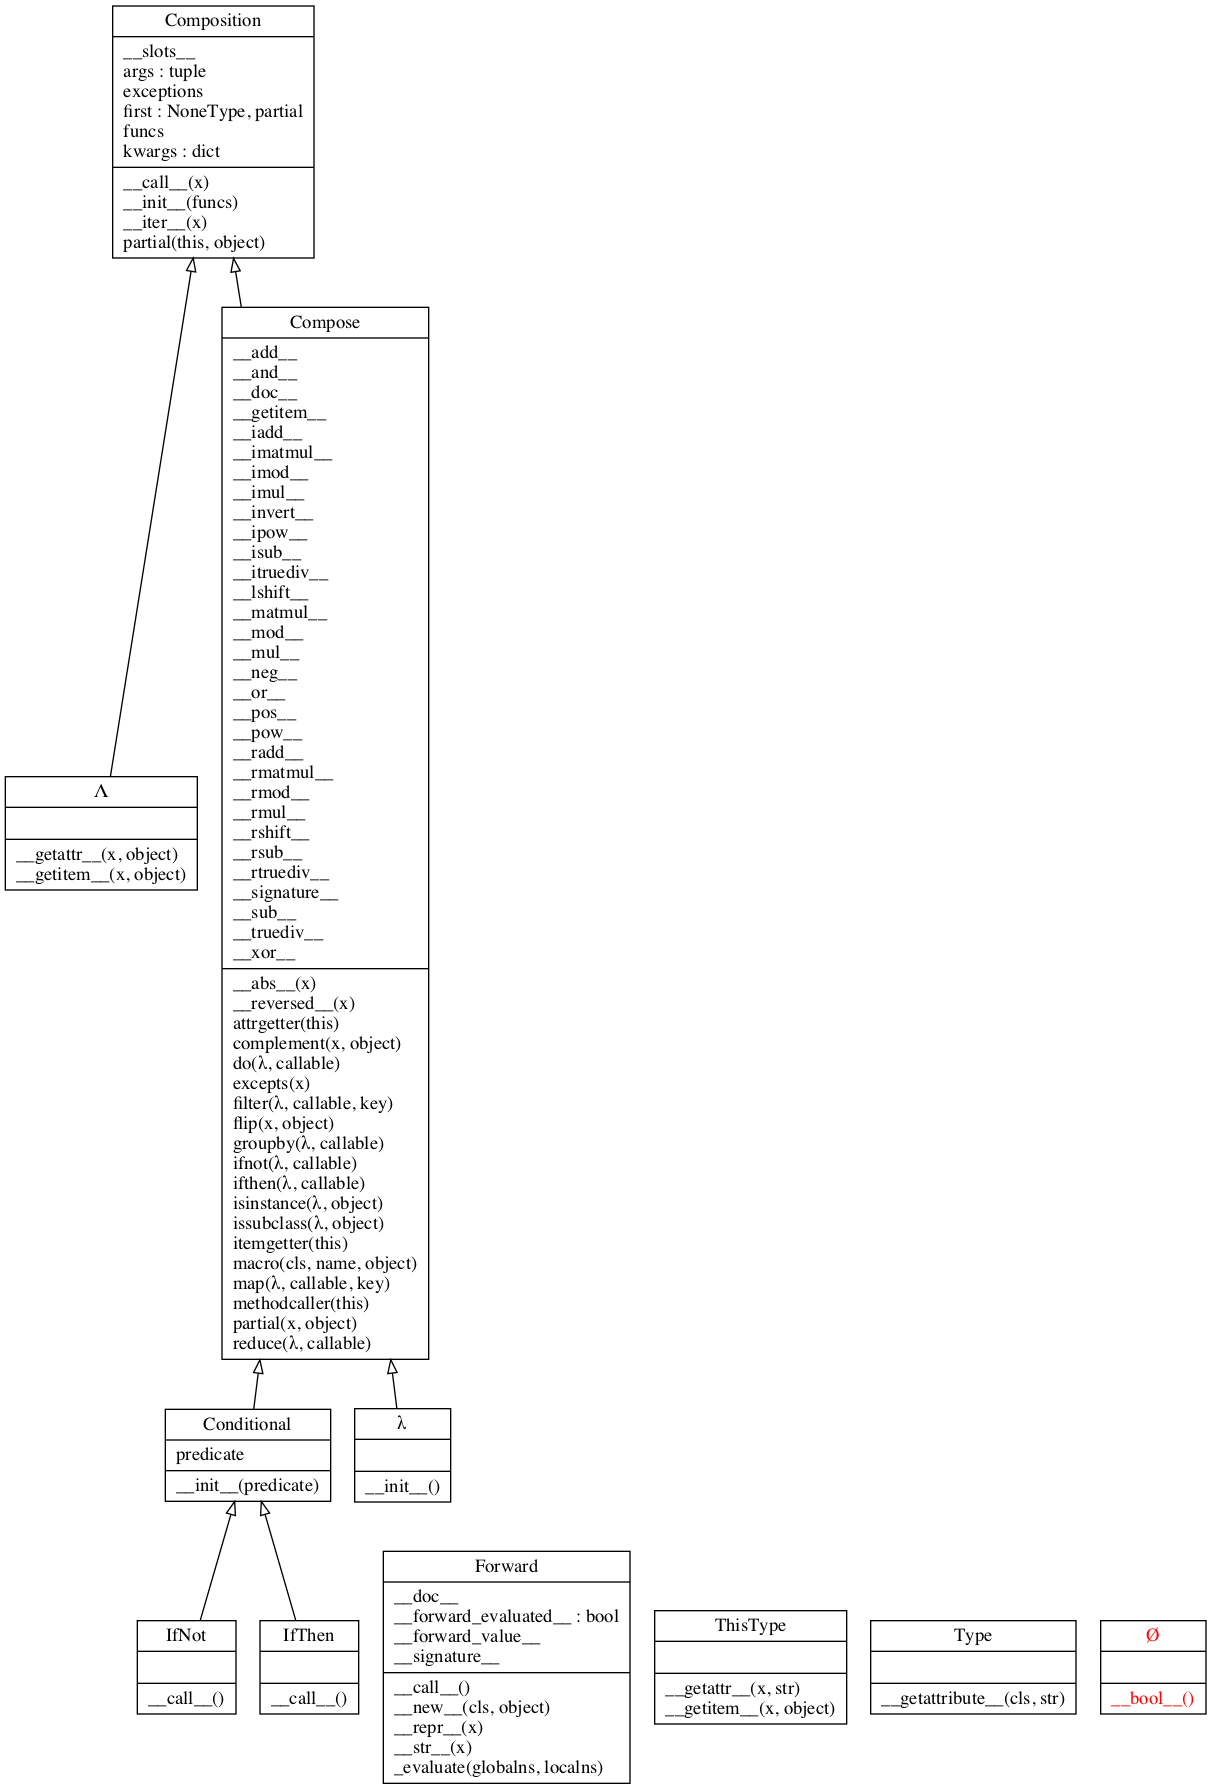

In [13]:
    if __name__ == '__main__':
        if 'runtime' in sys.argv[-1]:
            from IPython import get_ipython, display
            import doctest; display.display(doctest.testmod(optionflags=doctest.ELLIPSIS), __import__('IPython').display.Markdown(__test__[__name__]))
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True poser.ipynb
            !pyreverse -o png -pposer -fALL poser
            #!pytest test_poser.ipynb --doctest-modules
            display.display(display.Image('classes_poser.png'))
        else:
            print('run from cli')